<a href="https://colab.research.google.com/github/software-dev2010/Sentence-Classification-in-Medical-Abstracts./blob/main/NLP_ProjectUsingTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Confirm access to a GPU
Since we're going to be building deep learning models, let's make sure we have a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

If you don't have access to a GPU, the models we're building here will likely take up to 10x longer to run.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-398e5605-bb47-bd7f-71c0-92446a1bf6a1)


In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

## Get data
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 22.09 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Checking the contents of the downloaded repository, you can see there are four folders.
Each contains a different version of the PubMed 200k RCT dataset.
Looking at the README file from the GitHub page, we get the following information:
PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.
To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.

# Let's check the file contents.

In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


 Looks like we've got three separate text files:

    1)train.txt - training samples.

    2)dev.txt - dev is short for development set, which is another name for

    3)validation set (in our case, we'll be using and referring to this file as our validation set).

    4)test.txt - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocess data
We've downloaded the data but we haven't even looked at it yet.
**Because our data is in the form of text files, let's write some code to read each of the lines in a target file.**

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

Alright, we've got a little function, get_lines() which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data (train.txt).

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 420 ms, sys: 91.7 ms, total: 511 ms
Wall time: 512 ms


(180040, 30212, 30135)

In [10]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our data is in DataFrame form, we can perform some data analysis on it.

In [12]:

# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

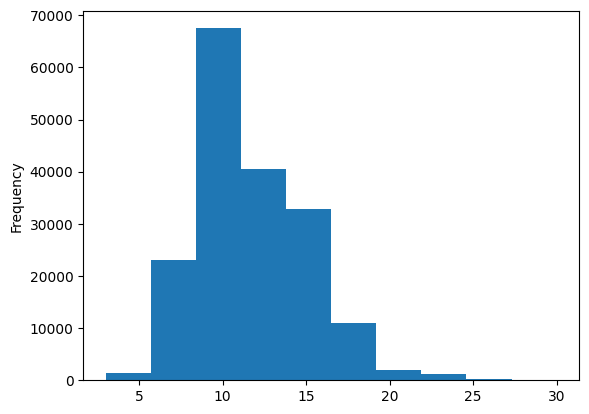

In [13]:
train_df.total_lines.plot.hist();

Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

## Get lists of sentences
When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)
We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [16]:

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [17]:

# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))


## Creating a series of model experiments
We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline
Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [20]:

# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the calculate_results() function we created in the previous notebook and added it to our helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help us obtain the following:

    Accuracy
    Precision
    Recall
    F1-score
## Download helper functions script
Let's get our helper_functions.py script we've been using to store helper functions we've created in previous notebooks.

In [22]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-14 06:38:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-14 06:38:33 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:

# Import calculate_results helper function
from helper_functions import calculate_results

In [24]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models
But before we start building deeper models, we've got to create vectorization and embedding layers.
The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.
To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.
When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).
For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [26]:

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

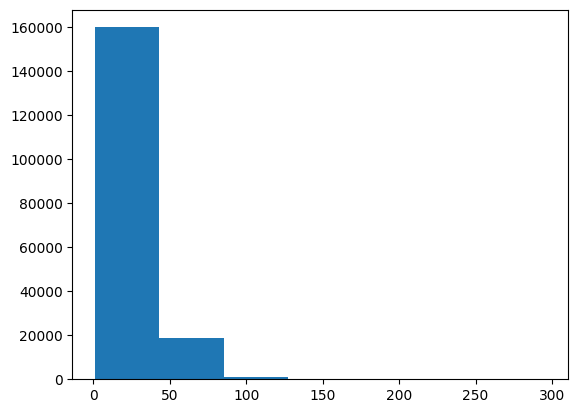

In [27]:

# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [28]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).
Why 95%?
We could use the max sentence length of the sentences in the training set.

In [29]:

# Maximum sentence length in the training set
max(sent_lens)


296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

🔑 Note: The steps we've gone through are good practice when working with a text corpus for a NLP problem. You want to know how long your samples are and what the distribution of them is. See section 4 Data Analysis of the PubMed 200k RCT paper for further examples.

## Create text vectorizer
Now we've got a little more information about our texts, let's create a way to turn it into numbers.
To do so, we'll use the TextVectorization layer from TensorFlow.
We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).
Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [30]:

# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [31]:

# Create text vectorizer

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
oxidative stress is thought to impair endothelial function associated with atherosclerosis , a leading cause of cardiovascular events .

Length of text: 19

Vectorized text:
[[1393  401   20 3346    6 6933 1033  149   81    7 2813    8 1530  887
     4  323  124    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()


{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding
Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our Embedding layer.

The input_dim parameter defines the size of our vocabulary. And the output_dim parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
oxidative stress is thought to impair endothelial function associated with atherosclerosis , a leading cause of cardiovascular events .

Sentence after vectorization (before embedding):
[[1393  401   20 3346    6 6933 1033  149   81    7 2813    8 1530  887
     4  323  124    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.02609273 -0.00043226 -0.00648709 ... -0.00270497 -0.00861924
    0.01603717]
  [-0.01445247  0.0491013   0.03994597 ...  0.03246308  0.03904362
   -0.02599855]
  [-0.04042752  0.03683249  0.03316731 ...  0.00135437 -0.01640021
    0.00750841]
  ...
  [-0.04301178  0.03183642 -0.04249543 ... -0.02905741  0.00868726
   -0.03955394]
  [-0.04301178  0.03183642 -0.04249543 ... -0.02905741  0.00868726
   -0.03955394]
  [-0.04301178  0.03183642 -0.04249543 ... -0.0290

## Create datasets
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.
Namely, the tf.data API provides methods which enable faster data loading.
tf.data: Build TensorFlow input pipelines
Better performance with the tf.data API
The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.
Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.
To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings
Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.
All of our deep models will follow a similar structure:
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.
We're also going to be following the standard machine learning workflow of:

Build model
Train model
Evaluate model (make predictions and compare to ground truth)

In [40]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [42]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.
Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [43]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 62s 89ms/step - loss: 0.9267 - accuracy: 0.6336 - val_loss: 0.6897 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.6586 - accuracy: 0.7566 - val_loss: 0.6360 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6160 - accuracy: 0.7760 - val_loss: 0.5940 - val_accuracy: 0.7849


In [44]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5961 - accuracy: 0.7871


[0.596103310585022, 0.7870713472366333]

In [45]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.6624219e-01, 1.4709240e-01, 5.5876128e-02, 3.0984679e-01,
        2.0942466e-02],
       [4.0870392e-01, 3.1334290e-01, 1.3126552e-02, 2.5538221e-01,
        9.4444407e-03],
       [1.4696659e-01, 8.6802673e-03, 1.5425758e-03, 8.4277183e-01,
        3.8631220e-05],
       ...,
       [1.0524366e-05, 6.8476965e-04, 7.7969657e-04, 4.5693600e-06,
        9.9852043e-01],
       [5.4814123e-02, 4.3742201e-01, 8.4970511e-02, 7.4387468e-02,
        3.4840590e-01],
       [1.8625225e-01, 6.7824584e-01, 5.0739765e-02, 4.2156350e-02,
        4.2605739e-02]], dtype=float32)

In [46]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70713623725672,
 'precision': 0.7841023246905552,
 'recall': 0.7870713623725671,
 'f1': 0.7848513353374853}

## Model 2: Feature extraction with pretrained token embeddings
Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.
To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

🔑 Note: We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.
This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

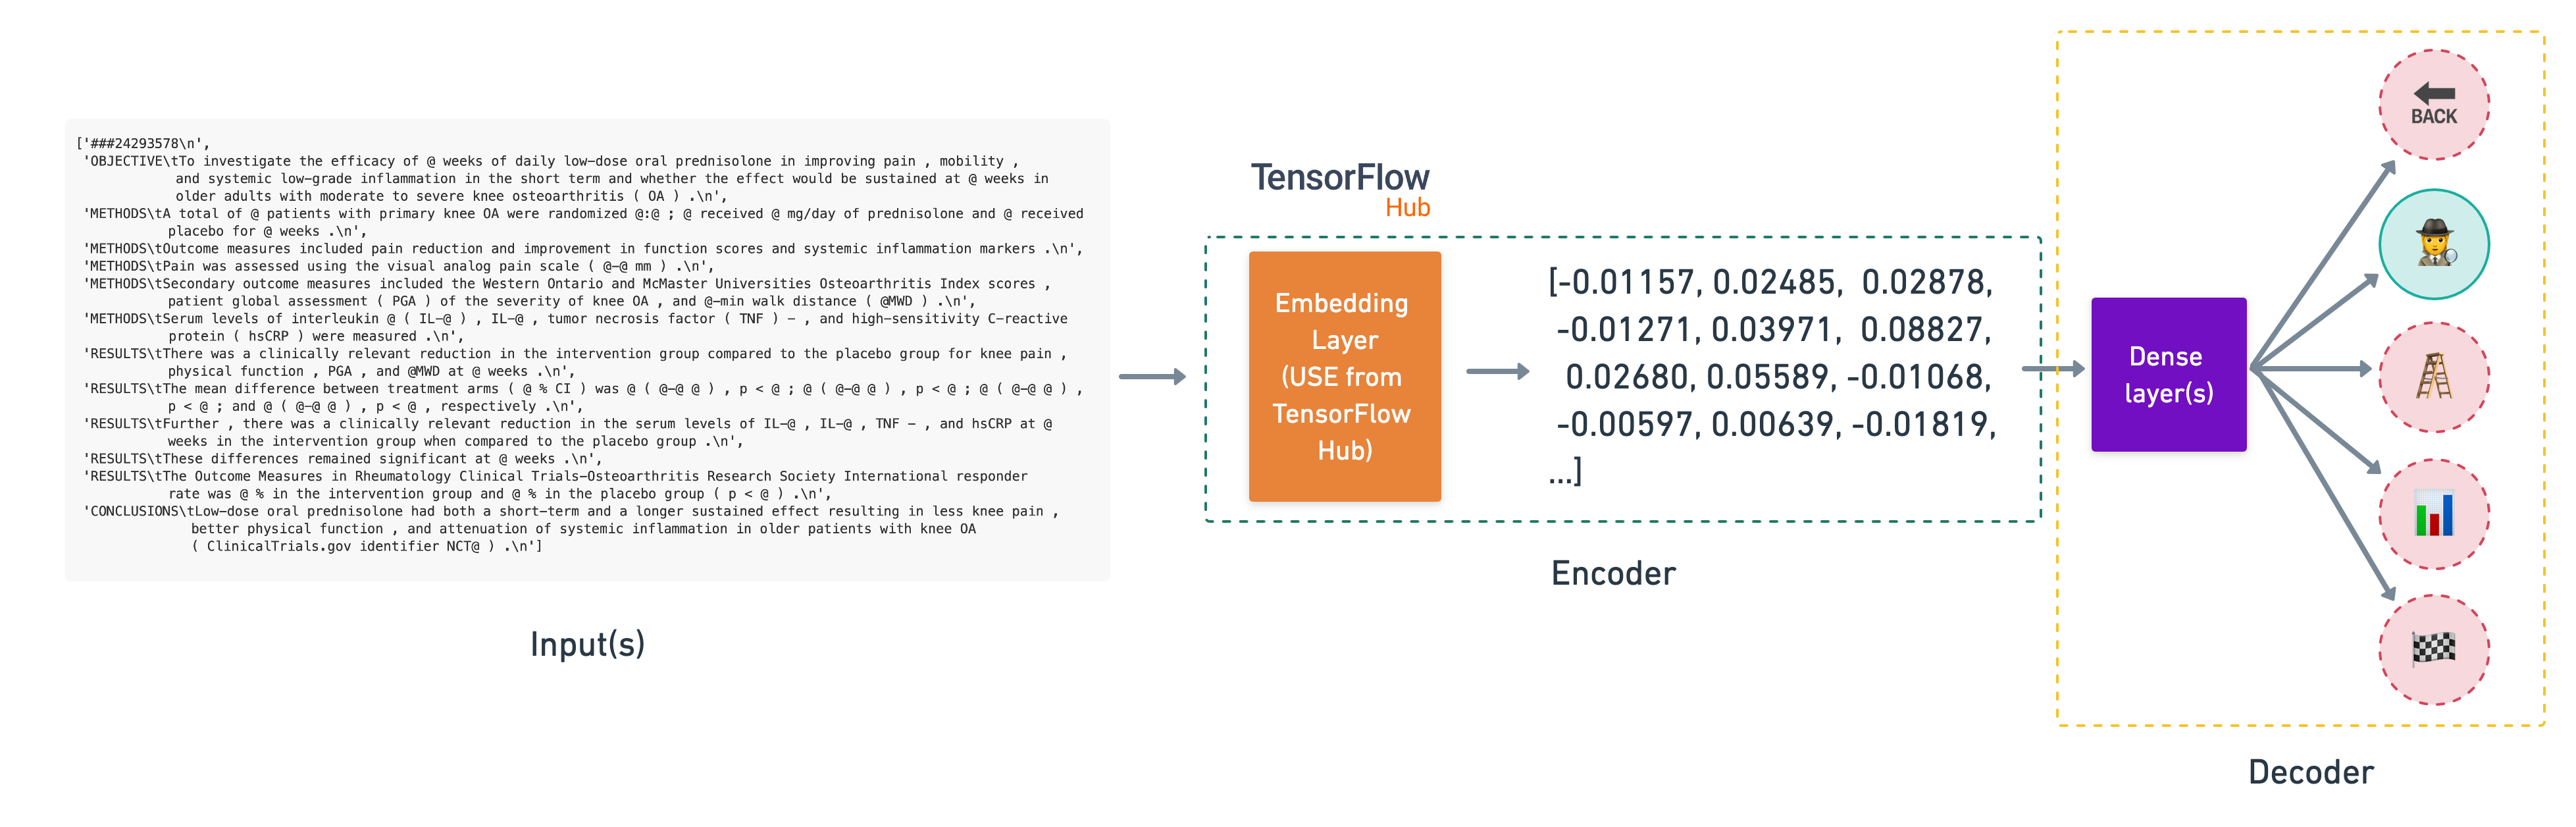

In [48]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
regional anesthesia is a commonly used technique in orthopedic procedures .

Sentence after embedding:
[-0.0533576   0.05508971  0.02109414 -0.00258268  0.0420217  -0.01105197
  0.02842933 -0.04986138 -0.00520025  0.00560015  0.08032813  0.04087682
  0.0099672   0.07719697  0.00588439 -0.02615869 -0.07229796  0.01906186
 -0.03074173 -0.05743434  0.01345695  0.03861496 -0.04114031  0.01019803
 -0.07280494  0.00374523  0.03843727  0.00278284  0.00423582 -0.00317795] (truncated output)...

Length of sentence embedding:
512


## Building and fitting an NLP feature extraction model from TensorFlow **Hub**

In [50]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [52]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 18ms/step - loss: 0.9155 - accuracy: 0.6501 - val_loss: 0.7967 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7685 - accuracy: 0.7021 - val_loss: 0.7545 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7519 - accuracy: 0.7119 - val_loss: 0.7371 - val_accuracy: 0.7144


In [53]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7399 - accuracy: 0.7144


[0.7399066090583801, 0.7143850326538086]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs


945/945 [==============================] - 12s 12ms/step


array([[0.41161275, 0.41200492, 0.00244445, 0.16579549, 0.00814248],
       [0.36080095, 0.47715852, 0.00420653, 0.15492775, 0.00290626],
       [0.22946611, 0.12577015, 0.02137092, 0.58618945, 0.03720345],
       ...,
       [0.00188428, 0.00729215, 0.06763671, 0.0009801 , 0.9222067 ],
       [0.00368329, 0.05143568, 0.19941731, 0.00172296, 0.74374074],
       [0.1519051 , 0.27142066, 0.52019167, 0.00637893, 0.05010366]],
      dtype=float32)

In [55]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [57]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.43850125777837,
 'precision': 0.7146625717614213,
 'recall': 0.7143850125777836,
 'f1': 0.7113548851830074}

## Model 3: Conv1D with character embeddings
Creating a character-level tokenizer
The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.



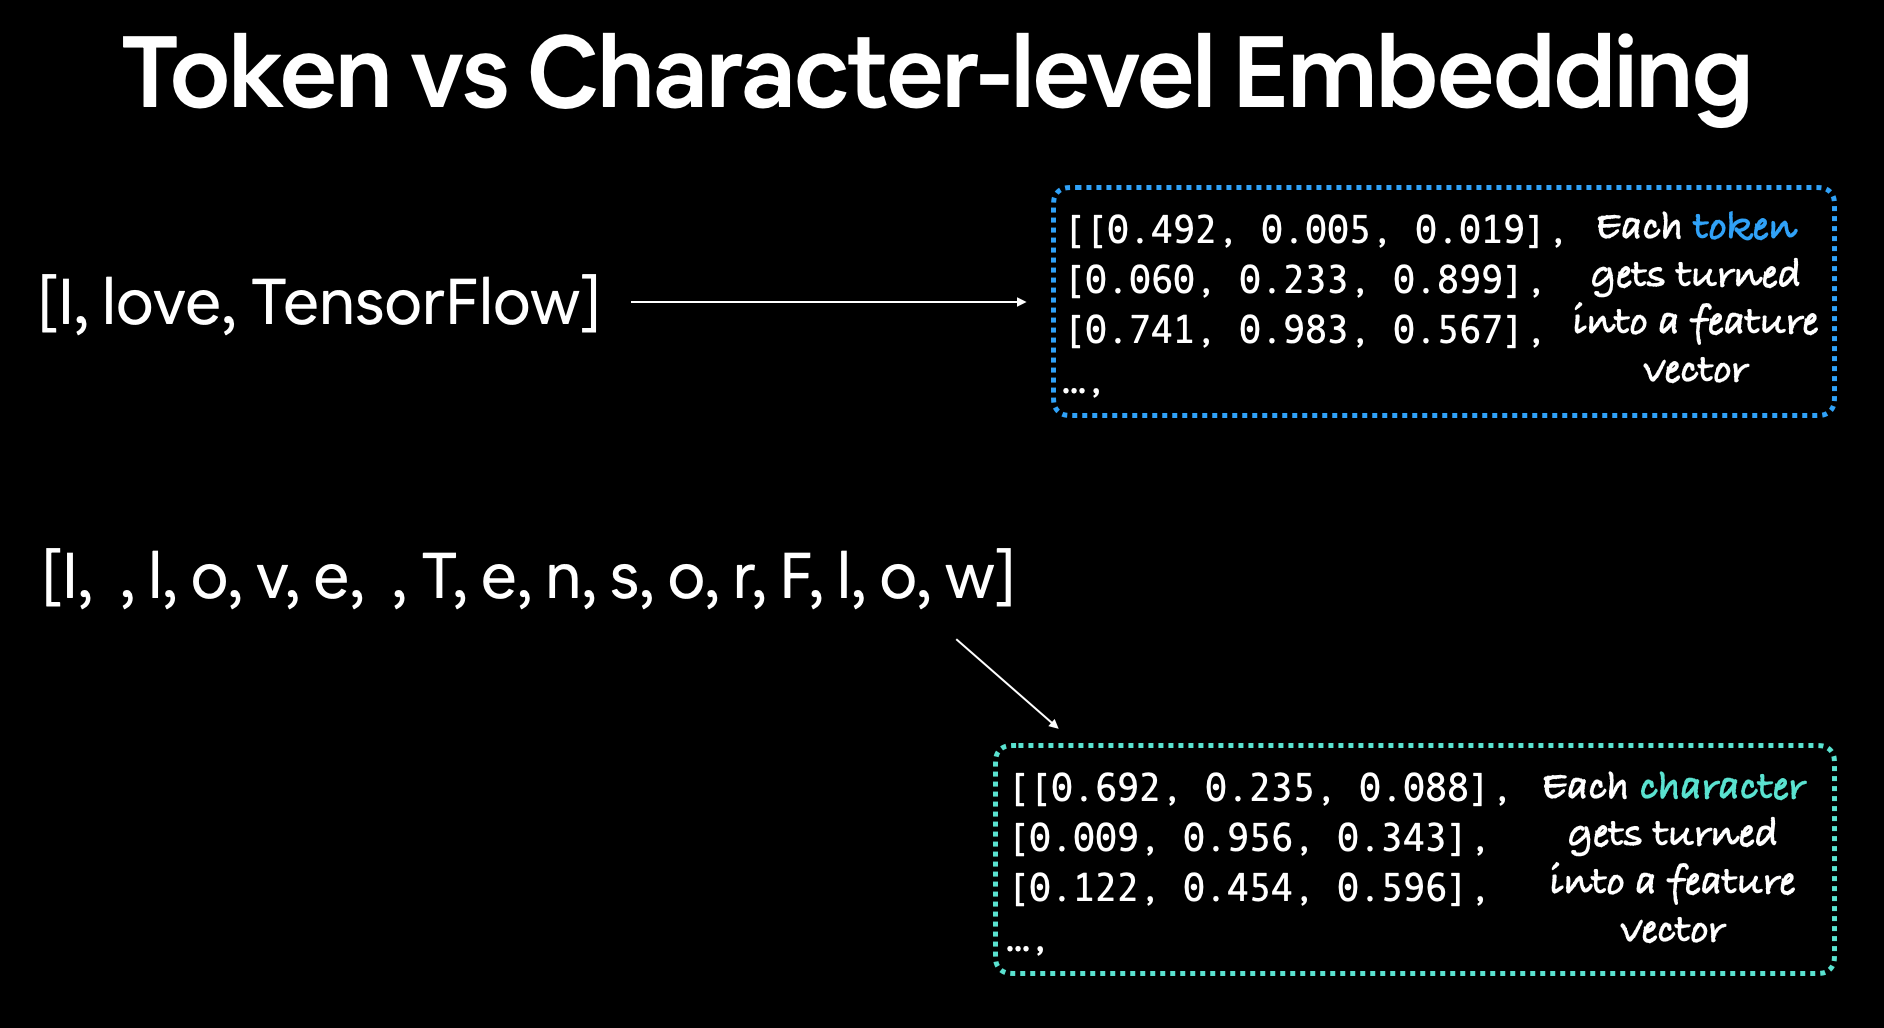

example of difference between token level and character level embeddings Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [58]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'r e g i o n a l   a n e s t h e s i a   i s   a   c o m m o n l y   u s e d   t e c h n i q u e   i n   o r t h o p e d i c   p r o c e d u r e s   .'

In [59]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [60]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

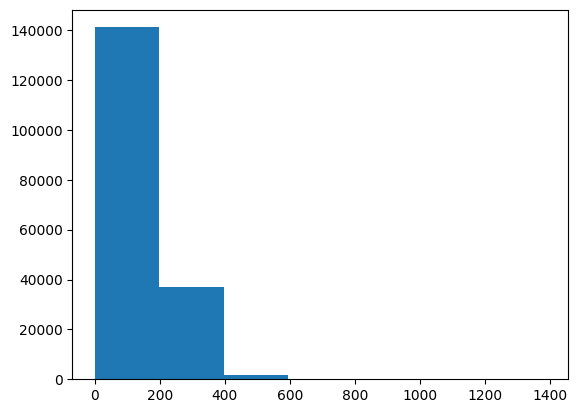

In [61]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [62]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [63]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
v i t a m i n   d   (   d   )   s t a t u s   i s   r e p o r t e d   t o   c o r r e l a t e   n e g a t i v e l y   w i t h   i n s u l i n   p r o d u c t i o n   a n d   i n s u l i n   s e n s i t i v i t y   i n   p a t i e n t s   w i t h   t y p e   @   d i a b e t e s   m e l l i t u s   (   t @ d m   )   .

Length of chars: 132

Vectorized chars:
[[21  4  3  5 15  4  6 10 10  9  3  5  3 16  9  4  9  8  2 14  7  8  3  2
  10  3  7 11  7  8  8  2 12  5  3  2  6  2 18  5  3  4 21  2 12 19 20  4
   3 13  4  6  9 16 12  4  6 14  8  7 10 16 11  3  4  7  6  5  6 10  4  6
   9 16 12  4  6  9  2  6  9  4  3  4 21  4  3 19  4  6 14  5  3  4  2  6
   3  9 20  4  3 13  3 19 14  2 10  4  5 22  2  3  2  9 15  2 12 12  4  3
  16  9  3 10 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  

## Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.
Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.
Our character-level embedding layer requires an input dimension and output dimension.
The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [67]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
v i t a m i n   d   (   d   )   s t a t u s   i s   r e p o r t e d   t o   c o r r e l a t e   n e g a t i v e l y   w i t h   i n s u l i n   p r o d u c t i o n   a n d   i n s u l i n   s e n s i t i v i t y   i n   p a t i e n t s   w i t h   t y p e   @   d i a b e t e s   m e l l i t u s   (   t @ d m   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.01858107  0.0421245  -0.01086318 ... -0.02967192 -0.02668011
   -0.02226573]
  [ 0.04355595  0.04378023 -0.03786816 ...  0.02729217 -0.01983604
    0.02908826]
  [ 0.02287707 -0.01501803  0.02130033 ...  0.04020667  0.01830318
    0.04364706]
  ...
  [ 0.01221149  0.0352422   0.00333219 ...  0.02074088 -0.02141839
   -0.00572019]
  [ 0.01221149  0.0352422   0.00333219 ...  0.02074088 -0.02141839
   -0.00572019]
  [ 0.01221149  0.0352422   0.00333219 ...  0.02074088 -0.02141839
   -0.00572019]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [68]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [70]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2525 - accuracy: 0.5044 - val_loss: 1.0211 - val_accuracy: 0.5904
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9891 - accuracy: 0.6039 - val_loss: 0.9253 - val_accuracy: 0.6363
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9233 - accuracy: 0.6356 - val_loss: 0.8602 - val_accuracy: 0.6702


In [72]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8816 - accuracy: 0.6597


[0.8816273212432861, 0.6597047448158264]

In [73]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.16975337, 0.2840715 , 0.04218774, 0.46718514, 0.03680226],
       [0.19523765, 0.6260407 , 0.01000724, 0.10025114, 0.06846327],
       [0.12349851, 0.40353888, 0.1487983 , 0.18187003, 0.14229424],
       ...,
       [0.00699479, 0.01757448, 0.11277872, 0.0187924 , 0.84385955],
       [0.01908589, 0.10581464, 0.1898295 , 0.03194169, 0.65332824],
       [0.5227362 , 0.28963798, 0.09537852, 0.08443516, 0.00781219]],
      dtype=float32)

In [74]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [75]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.9704753078247,
 'precision': 0.6512882073882236,
 'recall': 0.659704753078247,
 'f1': 0.6507396953700444}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.
So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.
To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:
Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) 5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [77]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

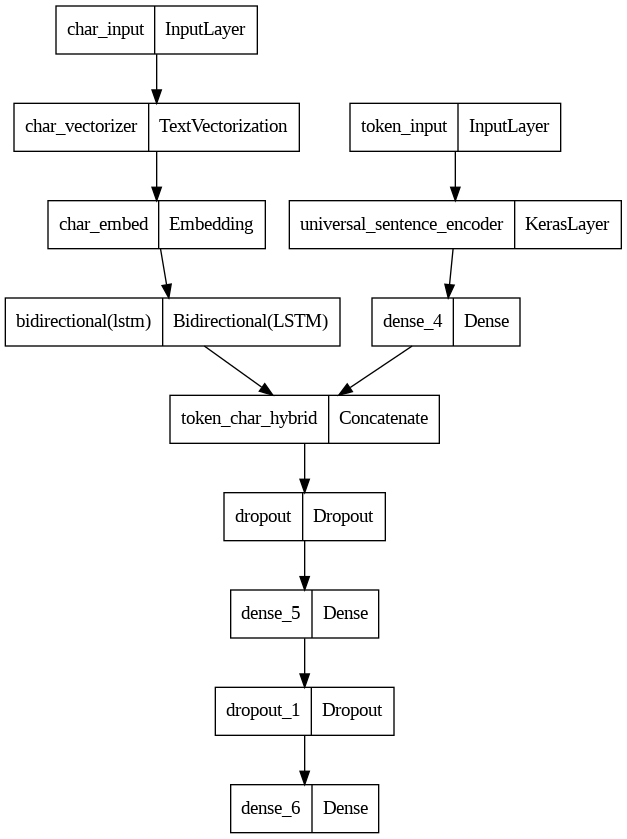

In [78]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [80]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 47ms/step - loss: 0.9672 - accuracy: 0.6154 - val_loss: 0.7833 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7948 - accuracy: 0.6910 - val_loss: 0.7147 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7669 - accuracy: 0.7084 - val_loss: 0.6855 - val_accuracy: 0.7394


In [83]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6921 - accuracy: 0.7354


[0.6920677423477173, 0.7353700399398804]

In [84]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[4.3782419e-01, 3.5274285e-01, 3.3213587e-03, 2.0108663e-01,
        5.0250436e-03],
       [3.1943083e-01, 4.5159084e-01, 3.3392650e-03, 2.2370023e-01,
        1.9388016e-03],
       [3.3341938e-01, 1.7083259e-01, 5.4301329e-02, 3.9654416e-01,
        4.4902511e-02],
       ...,
       [4.2500027e-04, 3.9556902e-03, 4.9225070e-02, 1.3562052e-04,
        9.4625860e-01],
       [4.6286061e-03, 5.0129071e-02, 2.2355500e-01, 1.7459390e-03,
        7.1994138e-01],
       [2.6446250e-01, 3.0710194e-01, 3.5911897e-01, 2.0840896e-02,
        4.8475634e-02]], dtype=float32)

In [85]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [86]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.53700516351118,
 'precision': 0.7354366647785859,
 'recall': 0.7353700516351118,
 'f1': 0.7334810495094473}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings
It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called feature engineering.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

OBJECTIVE ...
METHODS ...
METHODS ...
METHODS ...
RESULTS ...
CONCLUSIONS ...
Or

BACKGROUND ...
OBJECTIVE ...
METHODS ...
METHODS ...
RESULTS ...
RESULTS ...
CONCLUSIONS ...
CONCLUSIONS ...
Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

Sentence 1 of 10 ...
Sentence 2 of 10 ...
Sentence 3 of 10 ...
Sentence 4 of 10 ...
...
You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [87]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create positional embeddings

Since our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

🔑 Note: When it comes to one-hot-encoding our features, Scikit-Learn's OneHotEncoder class is another viable option here.

In [88]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

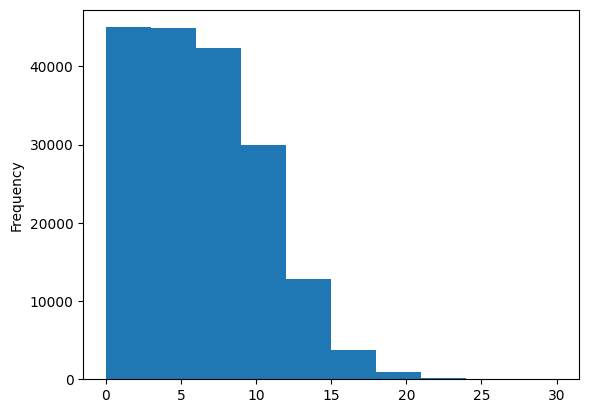

In [89]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [90]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [91]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [92]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

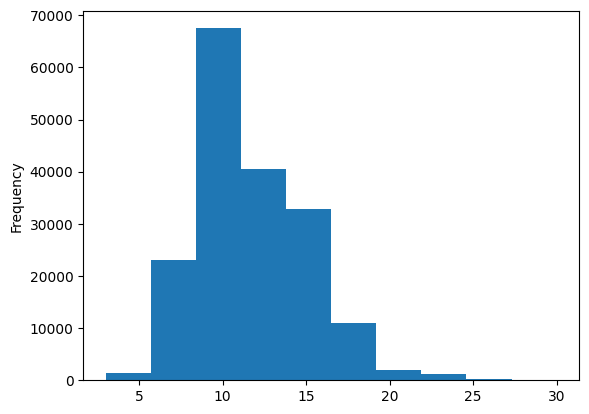

In [93]:

# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

Building a tribrid embedding model


More specifically we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) 6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 7. Create an output layer to accept the tribrid embedding and output predicted label probabilities 8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model


In [96]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [97]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

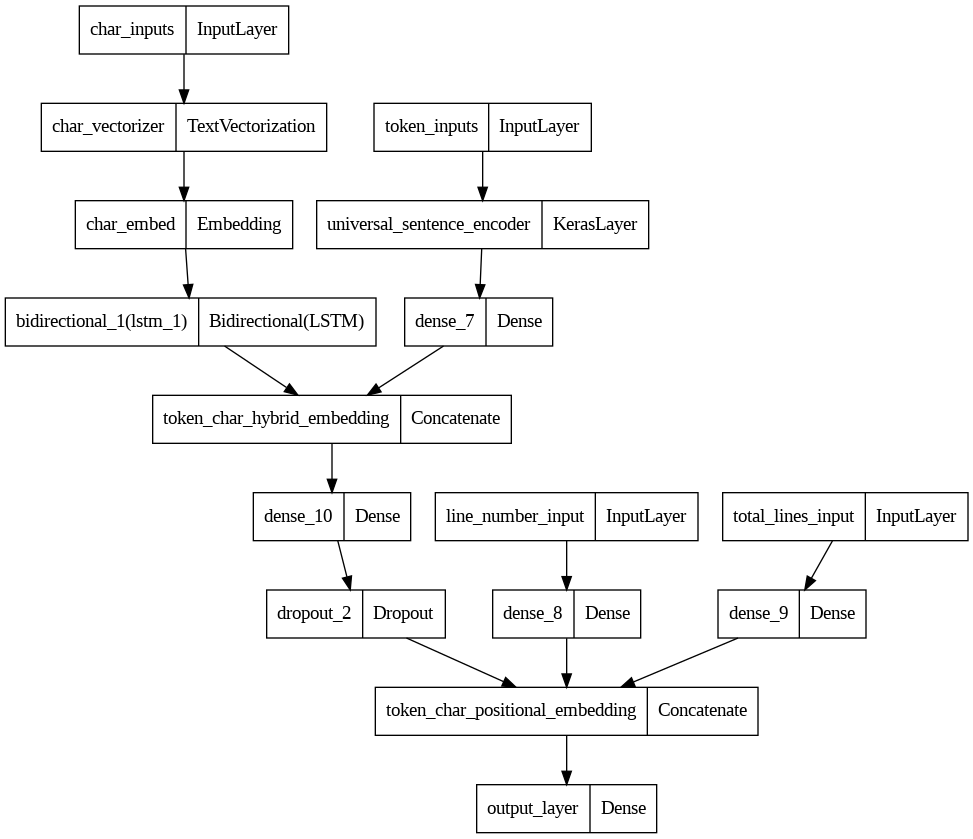

In [98]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [99]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)


<keras.src.engine.input_layer.InputLayer object at 0x7cc09c60ac80> True
<keras.src.engine.input_layer.InputLayer object at 0x7cc09cf60850> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7cc108261e70> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7cc186cbfa90> False
<keras.src.layers.core.embedding.Embedding object at 0x7cc09cf63dc0> True
<keras.src.layers.core.dense.Dense object at 0x7cc09c60a590> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7cc09c31b310> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7cc09c492050> True
<keras.src.engine.input_layer.InputLayer object at 0x7cc10818ca90> True
<keras.src.engine.input_layer.InputLayer object at 0x7cc1082f2410> True
<keras.src.layers.core.dense.Dense object at 0x7cc0f9e83400> True
<keras.src.layers.core.dense.Dense object at 0x7cc108176b60> True
<keras.src.layers.core.dense.Dense object at 0x7cc09c42a950> True
<keras.src.layers.regularization.dropout.

In [100]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Create tribrid embedding datasets and fit tribrid model

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

Train line numbers one-hot tensor (train_line_numbers_one_hot)
Train total lines one-hot tensor (train_total_lines_one_hot)
Token-level sequences tensor (train_sentences)
Char-level sequences tensor (train_chars)
We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [101]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [102]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 44ms/step - loss: 1.0995 - accuracy: 0.7220 - val_loss: 0.9827 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9689 - accuracy: 0.8163 - val_loss: 0.9496 - val_accuracy: 0.8324
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9519 - accuracy: 0.8225 - val_loss: 0.9383 - val_accuracy: 0.8338


In [103]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 24s 24ms/step


array([[0.48911437, 0.10759349, 0.01176953, 0.36848265, 0.02303998],
       [0.5202139 , 0.08099121, 0.03931993, 0.34751412, 0.0119608 ],
       [0.29289183, 0.1150052 , 0.12522863, 0.40593293, 0.06094133],
       ...,
       [0.03459391, 0.11139494, 0.03962031, 0.03527893, 0.77911186],
       [0.03053257, 0.28760177, 0.07942599, 0.02705696, 0.57538277],
       [0.23260884, 0.5771836 , 0.08979725, 0.04303562, 0.05737471]],
      dtype=float32)

In [104]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [105]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 83.25830795710314,
 'precision': 0.8315757477215228,
 'recall': 0.8325830795710314,
 'f1': 0.8316642906092182}

In [106]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.707136,0.784102,0.787071,0.784851
pretrained_token_embed,71.438501,0.714663,0.714385,0.711355
custom_char_embed_conv1d,65.970475,0.651288,0.659705,0.650740
hybrid_char_token_embed,73.537005,0.735437,0.735370,0.733481
tribrid_pos_char_token_embed,83.258308,0.831576,0.832583,0.831664


In [107]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


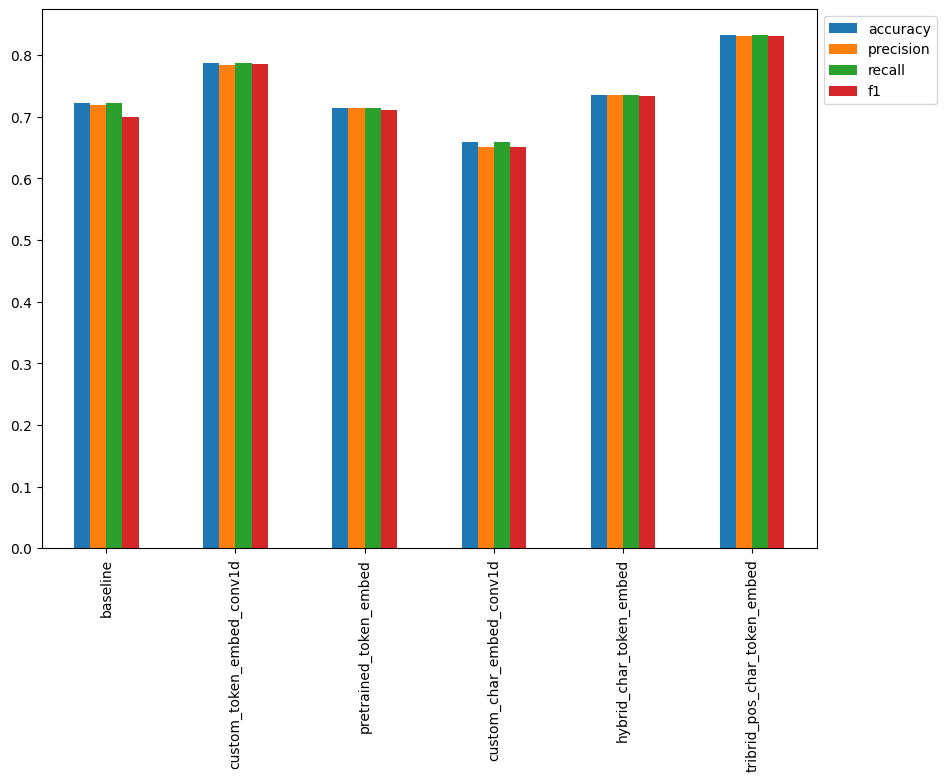

In [108]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

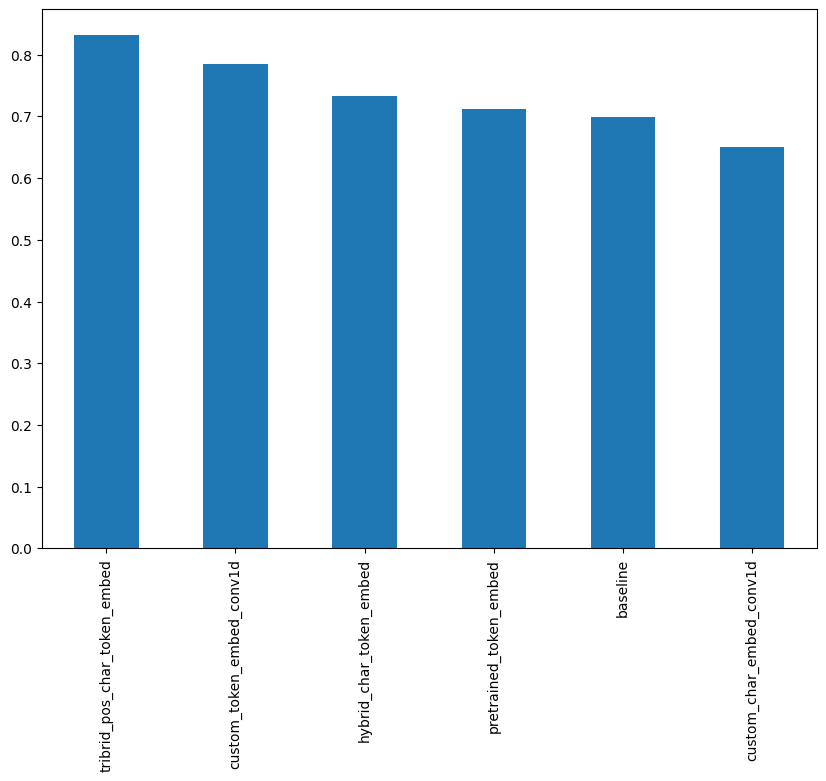

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [112]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [113]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [114]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-10-14 07:07:33--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 142.251.171.207, 142.250.159.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  89.6MB/s    in 14s     

2023-10-14 07:07:47 (66.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_mode

In [115]:

# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [116]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 20s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [117]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [118]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [119]:

# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

##Evaluate model on test dataset
 To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [120]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset


<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [121]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [122]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

In [123]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 16.1 s, sys: 661 ms, total: 16.7 s
Wall time: 17.9 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

In [124]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


In [125]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False


In [126]:

# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 